In [15]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Exploratory data analysis


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

# Objectif :

Comprendre nos données

Développer une première stratégie de modélisation 

# Résumé : 


## 5. Wordclouds & contenu lexical

### Non-catastrophe (`target = 0`)
- Mots fréquents : `like`, `just`, `i'm`, `it's`, `day`, `people`, `life`, etc.
- Ton personnel, émotionnel, parfois ironique ou banal.

### Catastrophe (`target = 1`)
- Mots fréquents : `suicide`, `disaster`, `killed`, `evacuated`, `wreckage`, `police`, etc.
- Ton dramatique, informatif, orienté crise ou urgence.

✅ Le contenu lexical brut est **déjà discriminant** entre les deux classes.

---

## 6. Analyse des localisations

| Classe                | Top localisations |
|-----------------------|-------------------|
| Non-catastrophe (0)   | New York, USA, London, CA, UK |
| Catastrophe (1)       | USA, Nigeria, India, California, UK |

📌 Les tweets catastrophes font plus souvent référence à des **zones de crise ou pays en développement**.

---

## 7. Analyse des `keywords`

| Keyword (target = 0) | Freq | Keyword (target = 1) | Freq |
|----------------------|------|-----------------------|------|
| body bags            | 40   | derailment            | 39   |
| armageddon           | 37   | outbreak              | 39   |
| harm                 | 37   | wreckage              | 39   |
| deluge               | 36   | oil spill             | 37   |
| ruin                 | 36   | typhoon               | 37   |

✅ Les `keywords` catastrophes sont **clairement liés à des événements réels**. À l'inverse, certains keywords du groupe 0 peuvent être ironiques ou hors contexte.

---

## Conclusion de l’EDA

- Les tweets urgents (catastrophes) se distinguent par leur **longueur, densité d’information, et lexique dramatique**.
- Certaines variables (`url_count`, `char_count`, `punctuation_count`) sont **fortement discriminantes**.
- `location` et `keyword` sont **secondaires** mais peuvent être utiles combinés au texte.
- L’analyse textuelle confirme que la **nature des mots** (suicide, disaster, evacuated…) est un signal fort.




In [16]:
df = pd.read_csv("../data/test_to_suli.csv")


## Apercu des valeurs 

In [17]:
df.head()

,keyword,location,text,target,word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,presence_url,hashtags,mentions,urls,tokens,clean_text
0,crash,NaN,motogp indianapolis espargaro layout worrie...,0,11,2,8.909091,108,15,0,1,NaN,NaN,"http://t.co/rny4l3sr7a, http://t.co/igx8xfz8ko","['motogp', 'indianapolis', 'espargaro', 'layou...",motogp indianapolis espargaro layout worry little
1,disaster,London,rt the devereaux disaster exciting scifi,0,11,1,9.000000,109,15,3,1,"thriller, scifi, kindle",amznfavorites,http://t.co/mw9ambgafq,"['devereaux', 'disaster', 'exciting', 'scifi']",devereaux disaster exciting scifi
2,war%20zone,Somewhere else...,this bed looks like a war zone,0,7,3,3.571429,31,1,0,0,NaN,NaN,NaN,"['bed', 'look', 'like', 'war', 'zone']",bed look like war zone
3,blew%20up,NaN,i hate people who tweet receipts but know it...,0,25,11,4.360000,134,5,0,0,NaN,NaN,NaN,"['hate', 'people', 'tweet', 'receipt', 'know',...",hate people tweet receipt know wrong wont take...
4,police,Indonesia,police kill hatchet wielding gunman who opened...,1,15,1,8.266667,138,11,0,1,NaN,NaN,http://t.co/tyd47nfl5x,"['police', 'kill', 'hatchet', 'wielding', 'gun...",police kill hatchet wielding gunman opened fir...


In [18]:
df.dtypes.value_counts()

object     8
int64      7
float64    1
dtype: int64

In [19]:
df.shape

(6478, 16)

<Axes: >

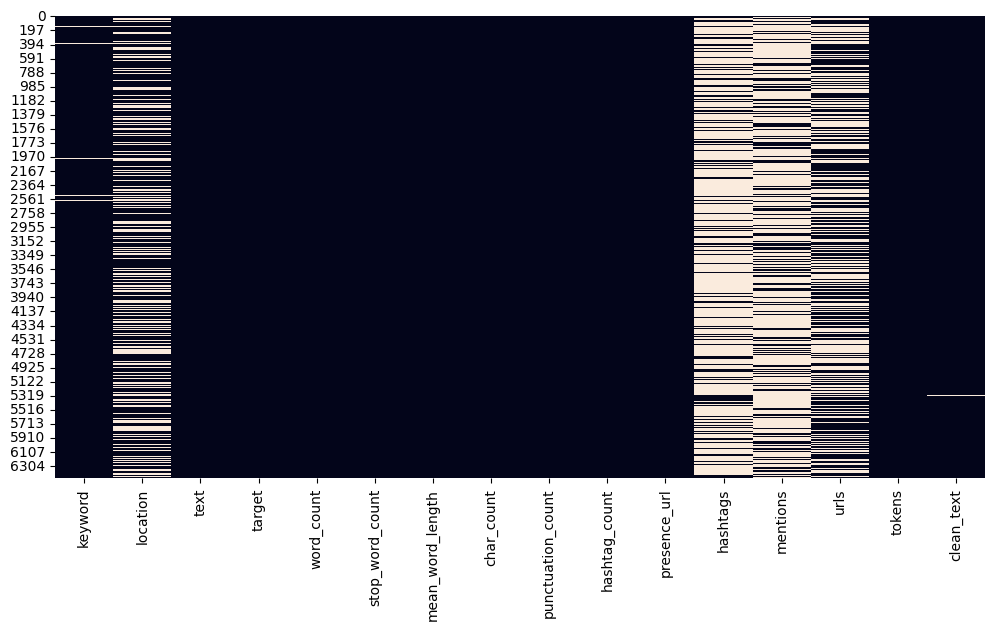

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)

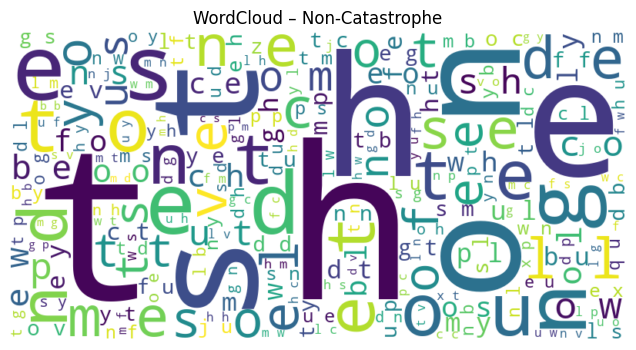

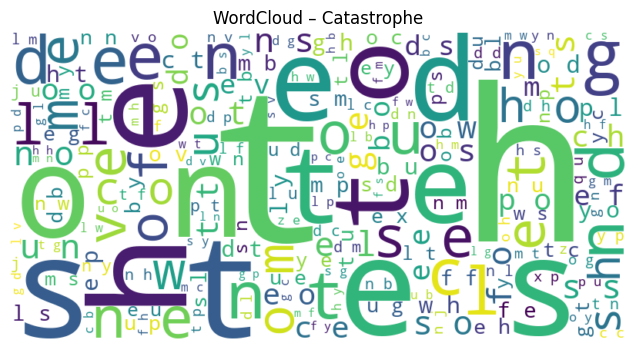

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_negative = df[df["target"] == 0]
df_positive = df[df["target"] == 1]
text_0 = " ".join(" ".join(tokens) for tokens in df_negative["tokens"].dropna())
text_1 = " ".join(" ".join(tokens) for tokens in df_positive["tokens"].dropna())

wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Classe 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Classe 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


In [25]:
from collections import Counter
from nltk.util import ngrams
import pandas as pd

def extract_ngrams(df, target, n=2, top_n=10):
    ngram_counts = Counter(
        ngram for tokens in df[df['target'] == target]['tokens']
        for ngram in ngrams(tokens, n)
    )
    return [" ".join(ng) for ng, _ in ngram_counts.most_common(top_n)]

# Créer le tableau résumé
ngrams_summary = pd.DataFrame({
    "Bigrams": extract_ngrams(df, 0, 2) + extract_ngrams(df, 1, 2),
    "Trigrams": extract_ngrams(df, 0, 3) + extract_ngrams(df, 1, 3),
    "Quadgrams": extract_ngrams(df, 0, 4) + extract_ngrams(df, 1, 4),
    "Target": ["0"] * 10 + ["1"] * 10
})

display(ngrams_summary)


,Bigrams,Trigrams,Quadgrams,Target
0,"' ,","' ,","' , '",0
1,",",", '","e ' ,",0
2,',"e ' ,","d ' ,",0
3,e ',"d ' ,","t ' ,",0
4,[ ',"t ' ,",", ' s",0
5,' ],' s,"y ' ,",0
6,i n,"y ' ,",", ' c",0
7,d ',' c,"n ' ,",0
8,' s,"n ' ,",", ' b",0
9,t ',n g ',"g ' ,",0


In [23]:
from collections import Counter

def analyse_top_elements(colonne, label, n=10):
    top_all = Counter(df[colonne].dropna().str.lower().str.split(", ").sum()).most_common(n)
    top_0 = Counter(df_negative[colonne].dropna().str.lower().str.split(", ").sum()).most_common(n)
    top_1 = Counter(df_positive[colonne].dropna().str.lower().str.split(", ").sum()).most_common(n)
    
    print(f"\n🔹 TOP {n} {label.upper()} (Global) :", [x[0] for x in top_all])
    print(f"   → Non-Catastrophe :", [x[0] for x in top_0])
    print(f"   → Catastrophe     :", [x[0] for x in top_1])

analyse_top_elements("hashtags", "Hashtag")
analyse_top_elements("mentions", "Mention")
analyse_top_elements("keyword", "Keyword")



🔹 TOP 10 HASHTAG (Global) : ['news', 'hot', 'prebreak', 'best', 'hiroshima', 'earthquake', 'islam', 'nowplaying', 'gbbo', 'jobs']
   → Non-Catastrophe : ['news', 'hot', 'prebreak', 'best', 'nowplaying', 'jobs', 'job', 'hiring', 'gbbo', 'islam']
   → Catastrophe     : ['news', 'hiroshima', 'earthquake', 'hot', 'prebreak', 'best', 'japan', 'india', 'yyc', 'isis']

🔹 TOP 10 MENTION (Global) : ['youtube', 'change', 'usatoday', 'foxnews', 'arianagrande', 'potus', 'emmerdale', 'ap', 'viralspell', 'stretcher']
   → Non-Catastrophe : ['youtube', 'arianagrande', 'emmerdale', 'usatoday', 'change', 'stretcher', 'invalid', 'towel', 'justinbieber', 'djicemoon']
   → Catastrophe     : ['youtube', 'foxnews', 'potus', 'ap', 'usagov', 'change', 'unsuckdcmetro', 'usatoday', 'nasahurricane', 'viralspell']

🔹 TOP 10 KEYWORD (Global) : ['fatalities', 'wreckage', 'outbreak', 'typhoon', 'flooding', 'oil%20spill', 'famine', 'windstorm', 'collision', 'debris']
   → Non-Catastrophe : ['harm', 'twister', 'wreck

In [24]:
import itertools
import networkx as nx

cooc_words_class1 = {'wreckage', 'airplane', 'accident', 'suicide', 'bomber', 'murder',
                     'airport', 'oil', 'spill', 'building', 'fire', 'outbreak'}

df["nb_words_in_cooc_class1"] = df["tokens"].apply(lambda tokens: sum(w in cooc_words_class1 for w in tokens))


ModuleNotFoundError: No module named 'networkx'

In [ ]:
top10_hashtags = {'earthquake', 'wildfire', 'hiroshima', 'genocide'}
top10_mentions = {'youtube', 'usatoday', 'ap', 'nasahurricane', 'foxnews',
                  'newyorker', 'sharethis', 'yahonews', 'cityofcalgary'}
top10_keywords = {'outbreak', 'wreckage', 'oil spill', 'collision', 'derailment',
                  'fire', 'evacuated', 'earthquake', 'airplane accident', 'sandstorm'}
top_bigrams = {'suicide bomber', 'burning building', 'oil spill', 'mass murder', 'severe thunderstorm'}

def clean_and_split(col):
    return col.fillna('').str.lower().str.split(", ")

df["has_top10_hashtag"] = clean_and_split(df["hashtags"]).apply(lambda lst: int(any(tag in top10_hashtags for tag in lst)))
df["nb_top10_mentions"] = clean_and_split(df["mentions"]).apply(lambda lst: sum(tag in top10_mentions for tag in lst))
df["has_top10_keyword"] = df["keyword"].fillna('').str.lower().apply(lambda k: int(k in top10_keywords))
df["has_top_bigram"] = df["text_clean"].apply(lambda text: int(any(bigram in text for bigram in top_bigrams)))


In [ ]:
num_cols = df.select_dtypes(include='number').columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features textuelles")
plt.show()